In [1]:
import copy
import os
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter,filtfilt
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import pickle
import control as ct
import cvxpy as cp

In [2]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

In [3]:
filename = 'continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

print(np.shape(A))

A_plasma = loadmat('plasma_ss_A_matrix').get('A')

print(np.shape(A_plasma))

B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

bop_A_vacuum = loadmat('BOP_A_matrix.mat').get('matrix')

print(np.shape(bop_A_vacuum))

object successfully saved to continuous_vacuum_ss_model
(12, 12)
(13, 13)
(12, 12)


In [4]:
def load_vacuum_shot(directory, flux): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []
    
    if flux == True:

        state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    
    else:
        state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time




In [5]:
def load_plasma_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                                 #One important change is that for a plasma shot we will look at the voltage, not the flux circuits
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4','i_tor']
    state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))



    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list




In [6]:
flux_trajectory_list,flux_inputs_list,flux_state_deriv_list,experiment_time = load_vacuum_shot('data/plasma_shots/flux_data/220816009',flux = True)
voltage_trajectory_list,voltage_inputs_list,voltage_state_deriv_list = load_plasma_shot('data/plasma_shots/220816009')
print(len(flux_trajectory_list))
print(len(voltage_trajectory_list))

voltage_trajectory_vacuum,voltage_inputs_vacuum,state_deriv_list,experiment_time = load_vacuum_shot('data/vacuum_shots_220816/good_shots/voltage_data',flux = False)

1
1


-0.9830543327193413


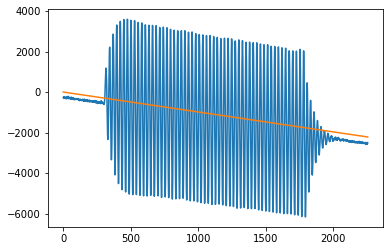

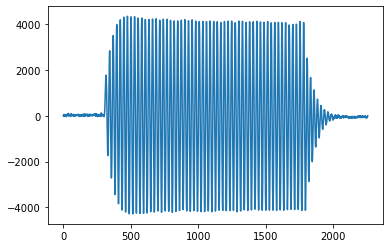

In [7]:
plt.plot(voltage_trajectory_vacuum[0][:,8])
vcoil_3 = voltage_trajectory_vacuum[0][:,8]

n = np.arange(len(voltage_trajectory_vacuum[0][:,8]))

linear_fit = (vcoil_3[-1] - vcoil_3[0])/len(n)

print(linear_fit)
plt.plot(linear_fit*n)

plt.figure()
#this looks good 
plt.plot(vcoil_3  -linear_fit*n - vcoil_3[0])

fixed_vcoil_3 = vcoil_3  -linear_fit*n - vcoil_3[0]

voltage_trajectory_vacuum[0][:,8] = fixed_vcoil_3

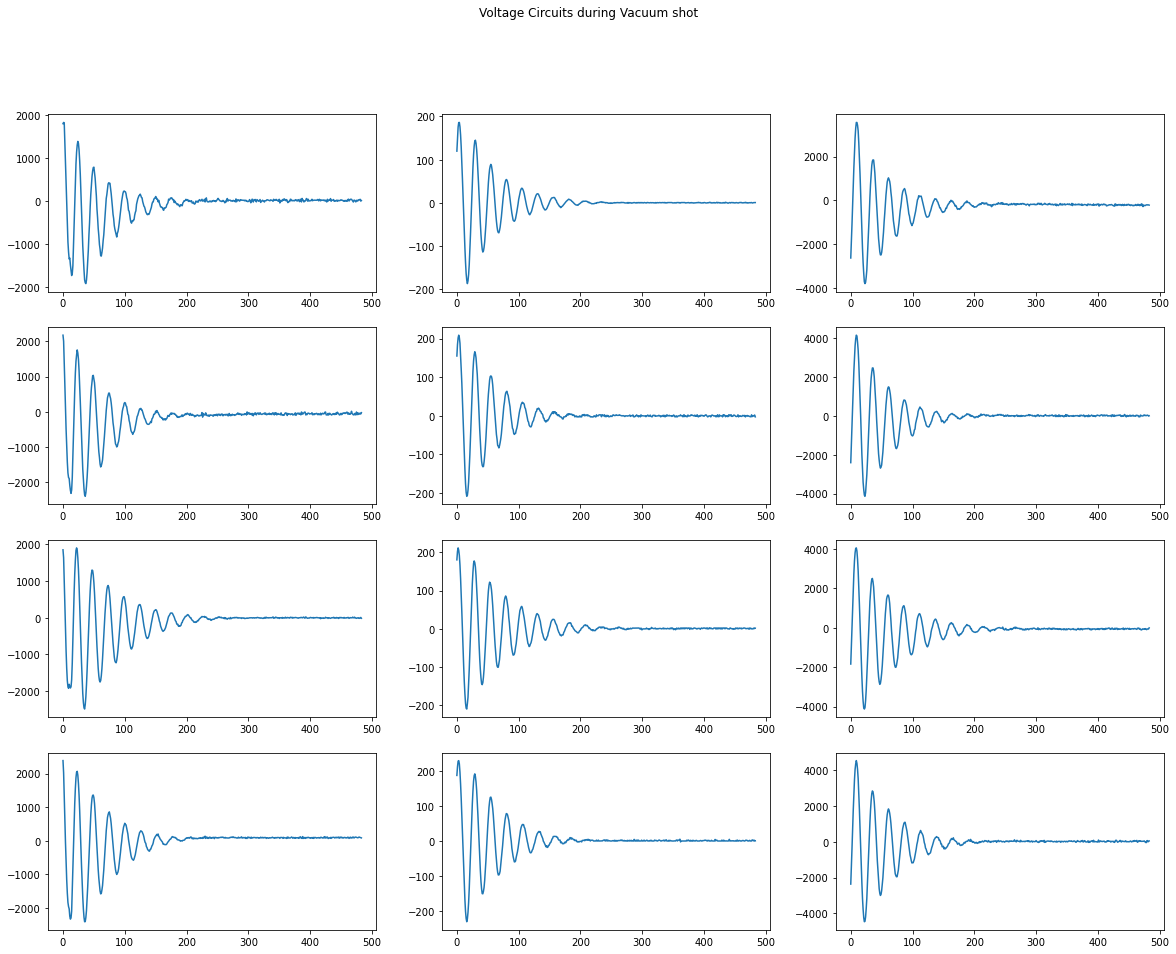

In [8]:
plt.figure(figsize = (20,15))
plt.suptitle('Voltage Circuits during Vacuum shot')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(voltage_trajectory_vacuum[0][1772::,i])

In [9]:
Atilde_vacuum_list = []
bop_vacuum_obj_list = []
xout_vacuum_list = []
for i in range(20):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = voltage_trajectory_vacuum[0].T[0:12,1772::], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = voltage_inputs_vacuum[0][1772::,:],
        test_voltage = voltage_inputs_vacuum[0][251::,:],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,#np.vstack((B,np.zeros((1,4)))),
        C = C,#np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_vacuum_list.append(Atilde)
    bop_vacuum_obj_list.append(bop_obj)
    xout_vacuum_list.append(xout)


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


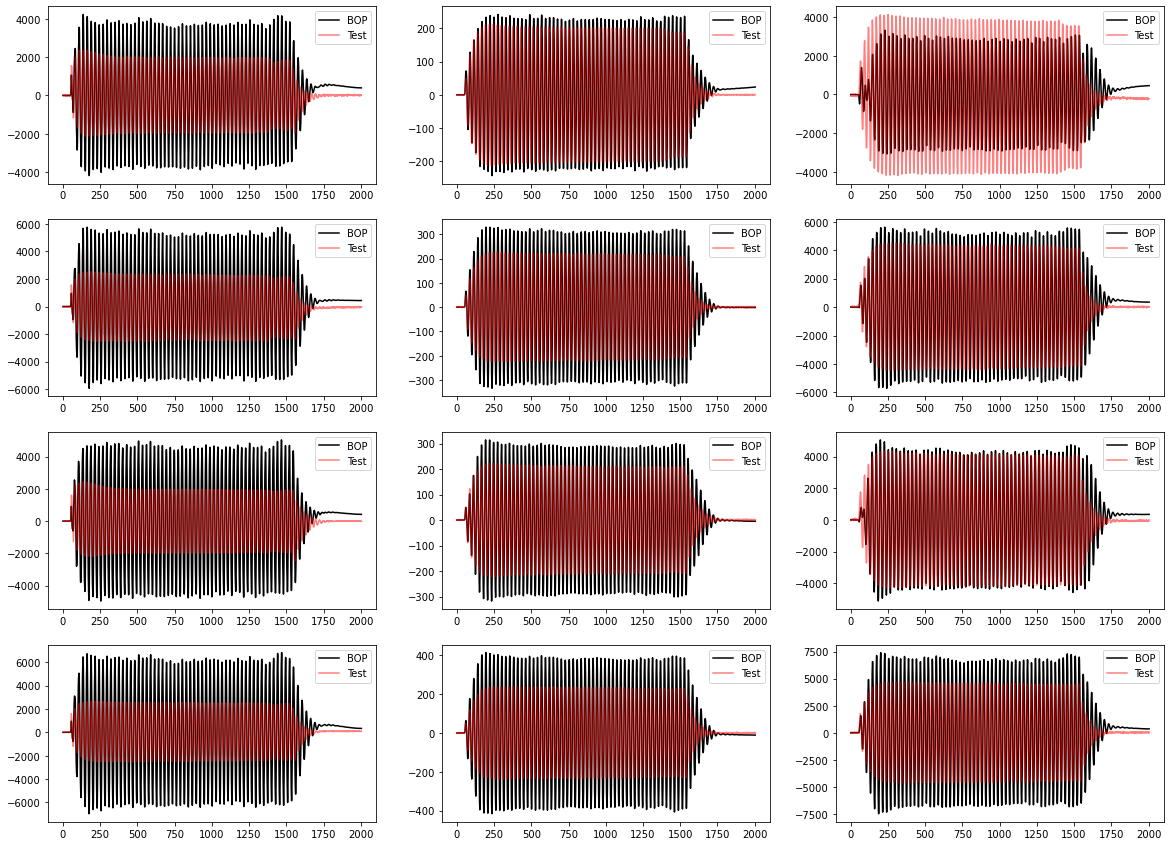

In [10]:
num = 8
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_vacuum_list[num][:,i]),'k')
    plt.plot(voltage_trajectory_vacuum[0][251::,i],'r',alpha = .5)
    plt.legend(['BOP','Test'])

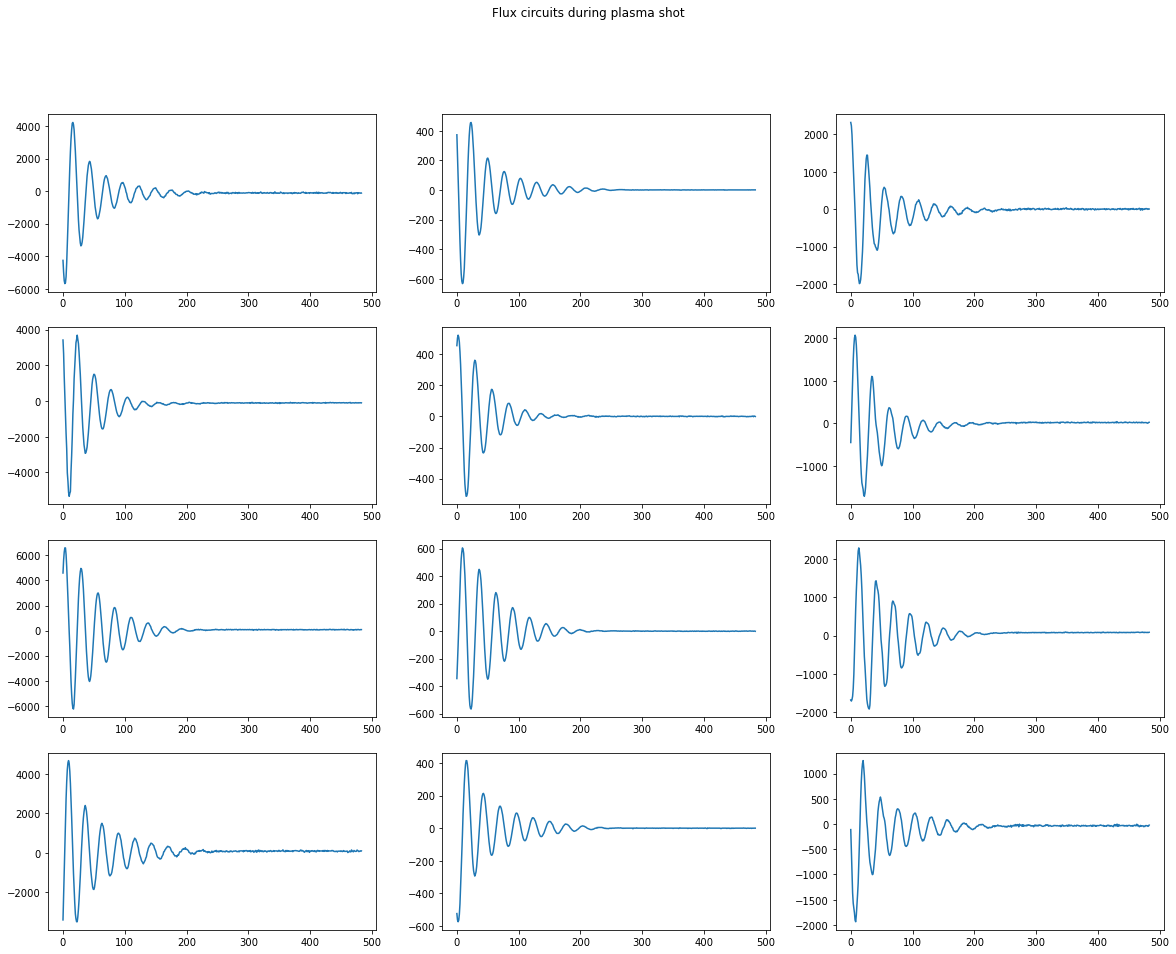

In [11]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_trajectory_list[0][1772::,i])
    plt.suptitle('Flux circuits during plasma shot')

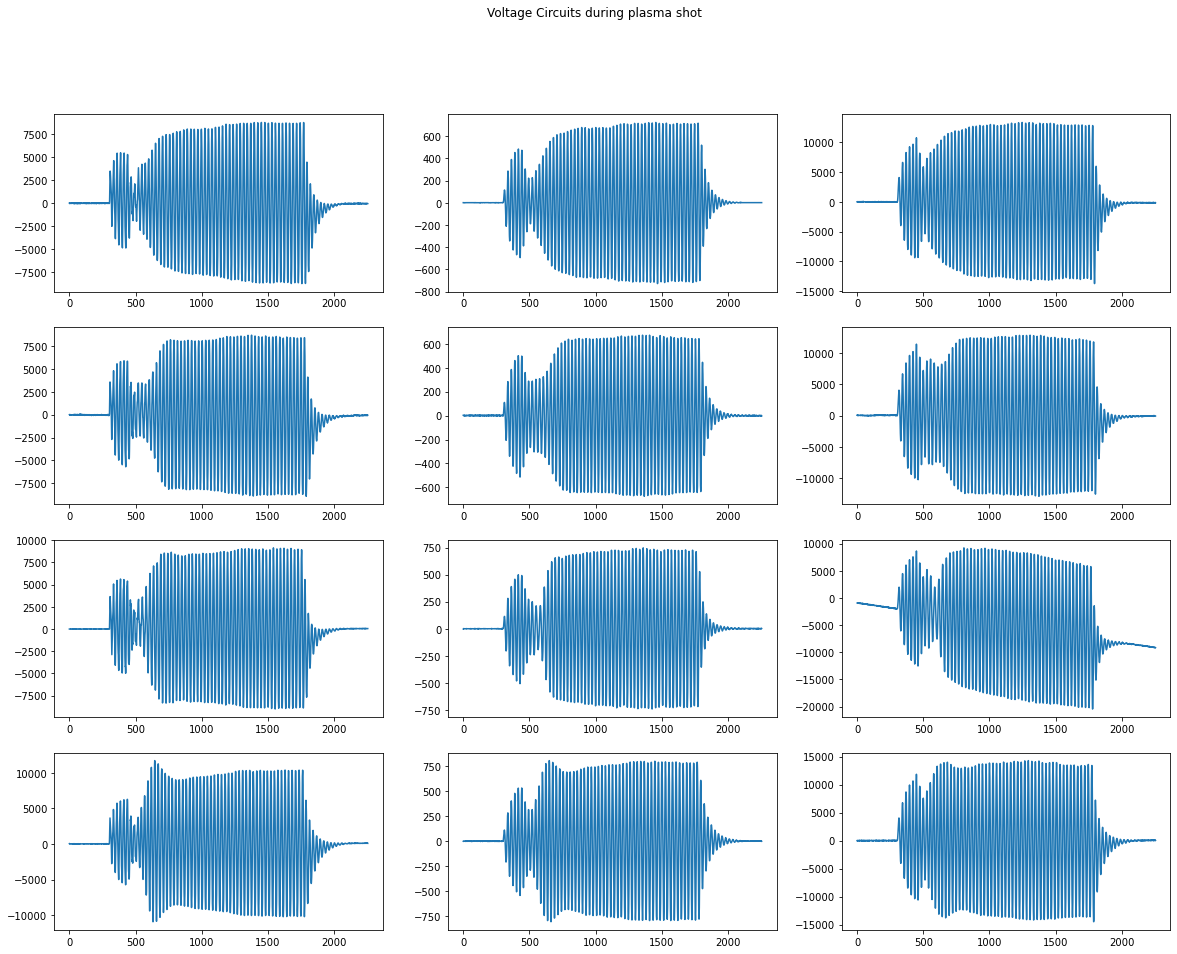

In [12]:
#need to correct the slant in one of the voltage coils.

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(voltage_trajectory_list[0][:,i])
    plt.suptitle('Voltage Circuits during plasma shot')

## Below is a simulation of what an analytic linear model of the flux circuits look like when a plasma is present. 

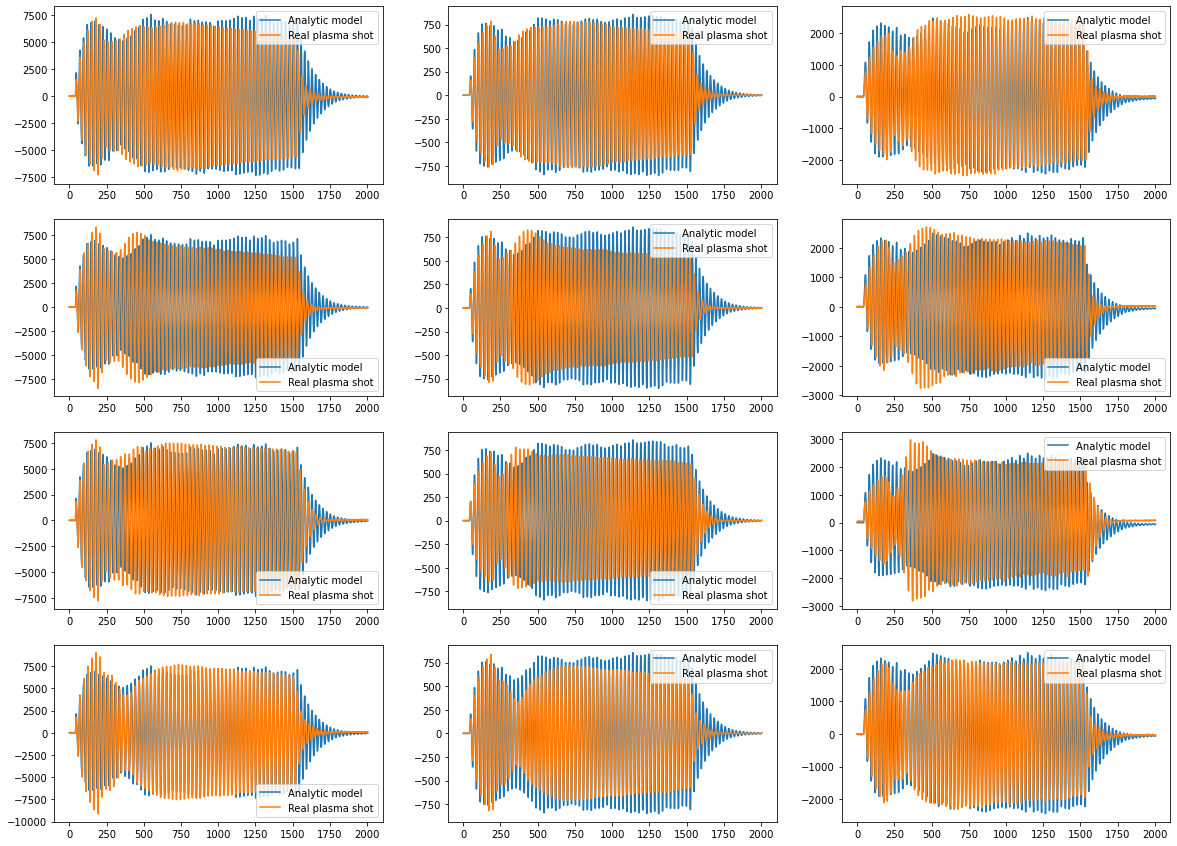

In [13]:
tout,yout,xout_plasma_ss = lsim((A_plasma,B_plasma,C_plasma,D),flux_inputs_list[0][251::,:],experiment_time[251::])
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_plasma_ss[:,i])
    plt.plot(flux_trajectory_list[0][251::,i])
    plt.legend(['Analytic model','Real plasma shot'])
    

-0.0250145882084756
7.274018946049606e-05
-0.07317765540906096
-0.0292933651284954
-0.0023769707543789494
-0.06018306229761702
0.02314773140011355
0.0020176830655294106
-3.64192853681496
0.019839343242687185
0.0
0.023293125723012807


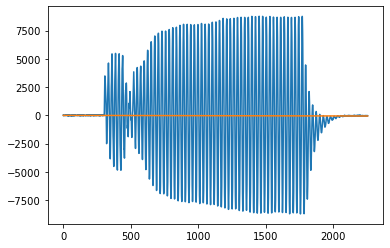

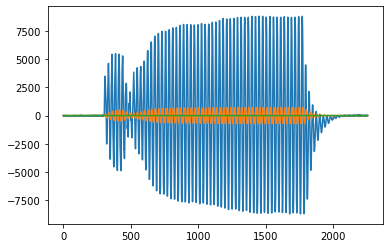

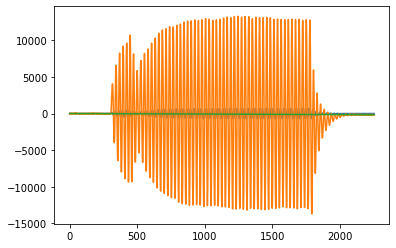

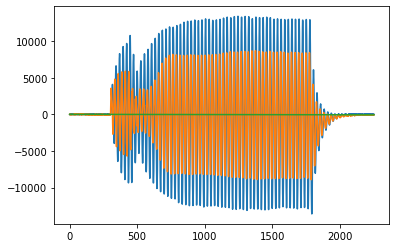

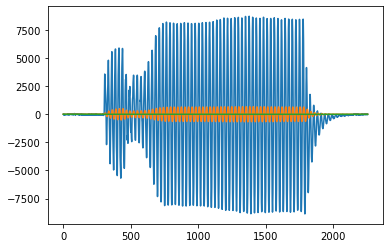

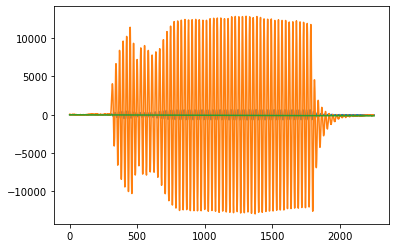

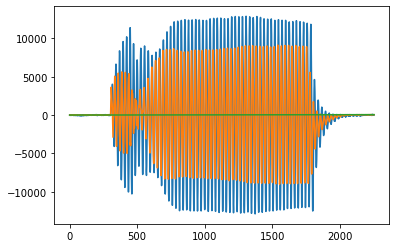

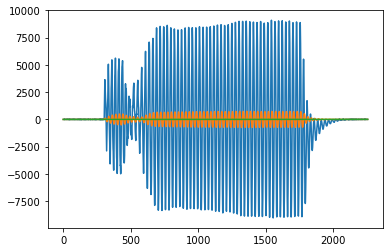

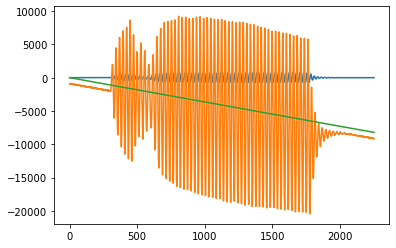

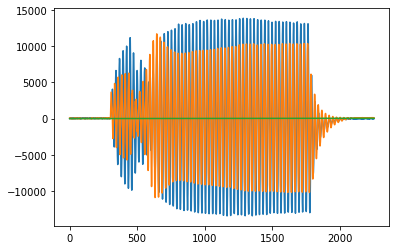

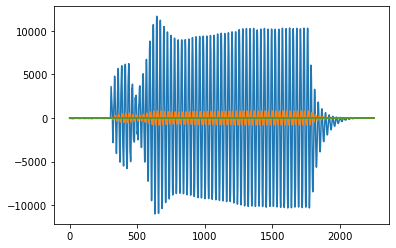

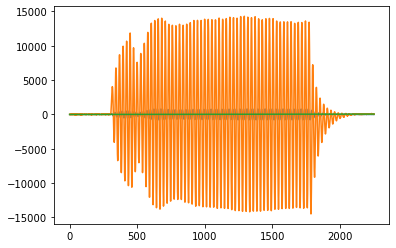

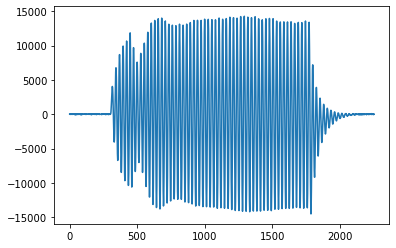

In [14]:
n = np.arange(len(voltage_trajectory_list[0][:,0]))

for i in range(12):
    
    plt.plot(voltage_trajectory_list[0][:,i])
    element = voltage_trajectory_list[0][:,i]


    linear_fit = (element[-1] - element[0])/len(n)

    print(linear_fit)
    plt.plot(linear_fit*n)

    plt.figure()
    #this looks good 
    plt.plot(element  -linear_fit*n - element[0])

    fixed_element = element  -linear_fit*n - element[0]

    voltage_trajectory_list[0][:,i] = fixed_element

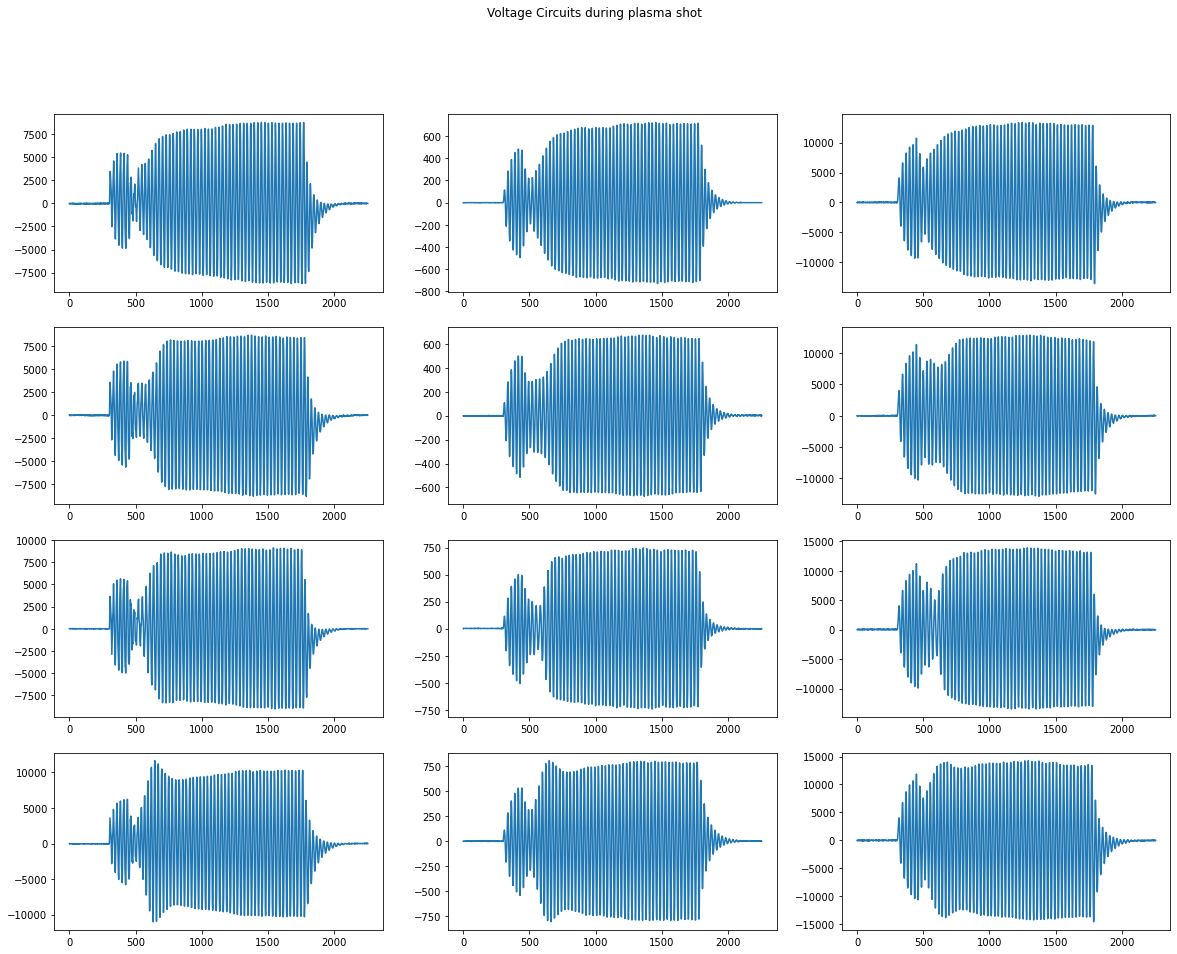

In [15]:

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(voltage_trajectory_list[0][:,i])
    plt.suptitle('Voltage Circuits during plasma shot')

In [16]:
print(np.shape(voltage_trajectory_list[0][:,12]))

#Add on itor to the flux trajectory list
flux_trajectory_list[0] = np.hstack((flux_trajectory_list[0],voltage_trajectory_list[0][:,12].reshape(len(experiment_time),1)))

print(np.shape(flux_trajectory_list[0]))

(2256,)
(2256, 13)


## BOP on Flux circuits during a plasma shot

In [17]:
Atilde_flux_list = []
bop_obj_flux_list = []
xout_flux_list = []
for i in range(30):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = flux_trajectory_list[0].T[0:13,1772::], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = flux_inputs_list[0][1772::,:],
        test_voltage = flux_inputs_list[0][251::,:],
            train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_flux_list.append(Atilde)
    bop_obj_flux_list.append(bop_obj)
    xout_flux_list.append(xout)


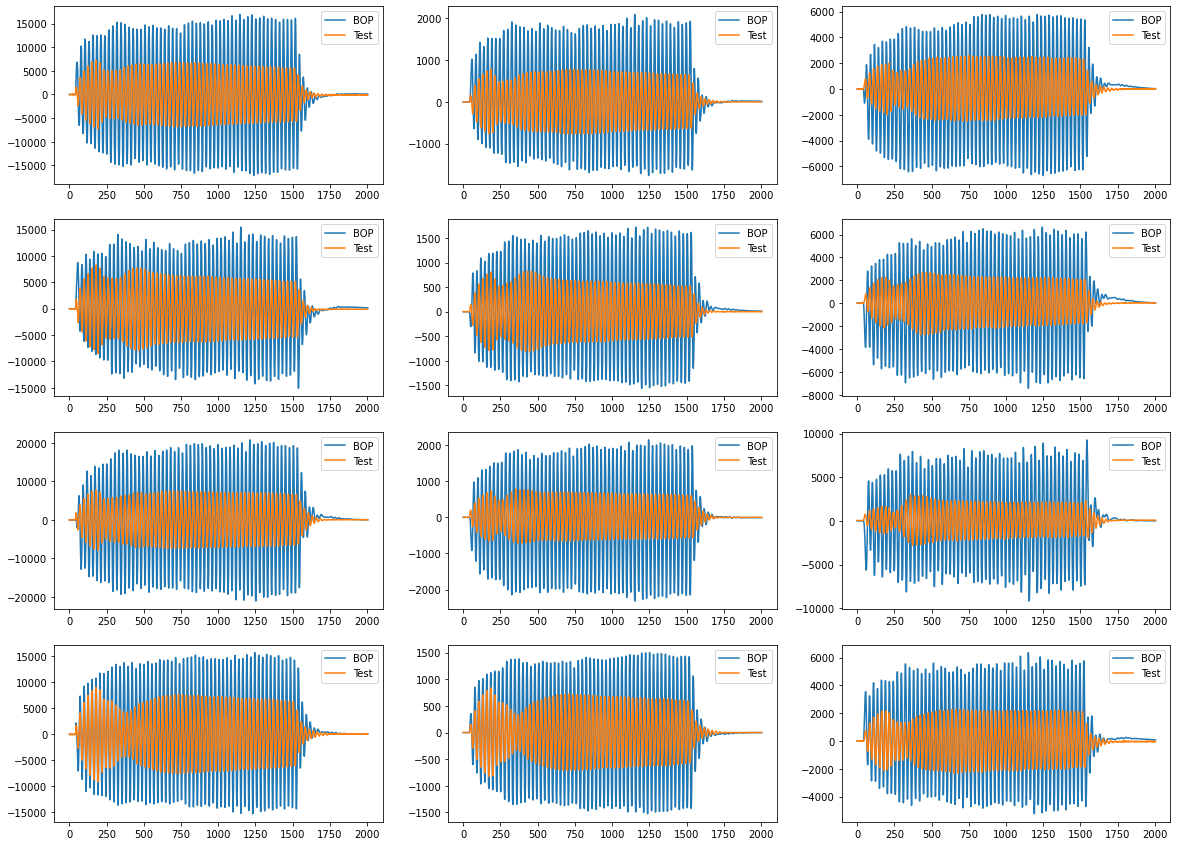

In [18]:
num = 5

#8


plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_flux_list[num][::,i]))
    plt.plot(flux_trajectory_list[0][251::,i])
    plt.legend(['BOP','Test'])

## BOP on voltage circuits during plasma shot

In [19]:
Atilde_list = []
bop_obj_list = []
xout_list = []
for i in range(30):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 30,
        training_set = voltage_trajectory_list[0].T[0:13,1772::], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = voltage_inputs_list[0][1772::,:],
        test_voltage = voltage_inputs_list[0][251::,:],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_list.append(Atilde)
    bop_obj_list.append(bop_obj)
    xout_list.append(xout)


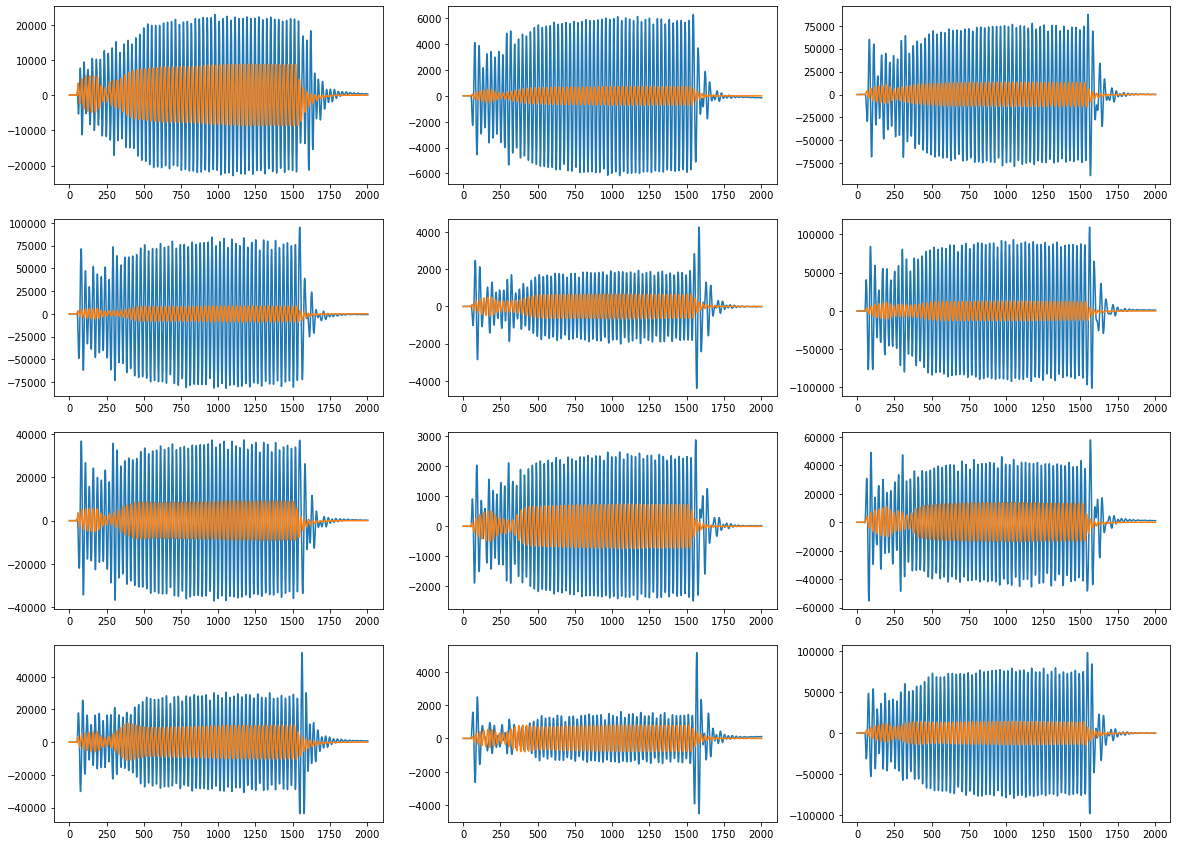

In [20]:
num = 9

plt.figure(figsize = (20,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_list[num][:,i]))
    plt.plot(voltage_trajectory_list[0][251::,i])

## We try 'post fitting' by projecting a point in the time series onto the DMD modes below

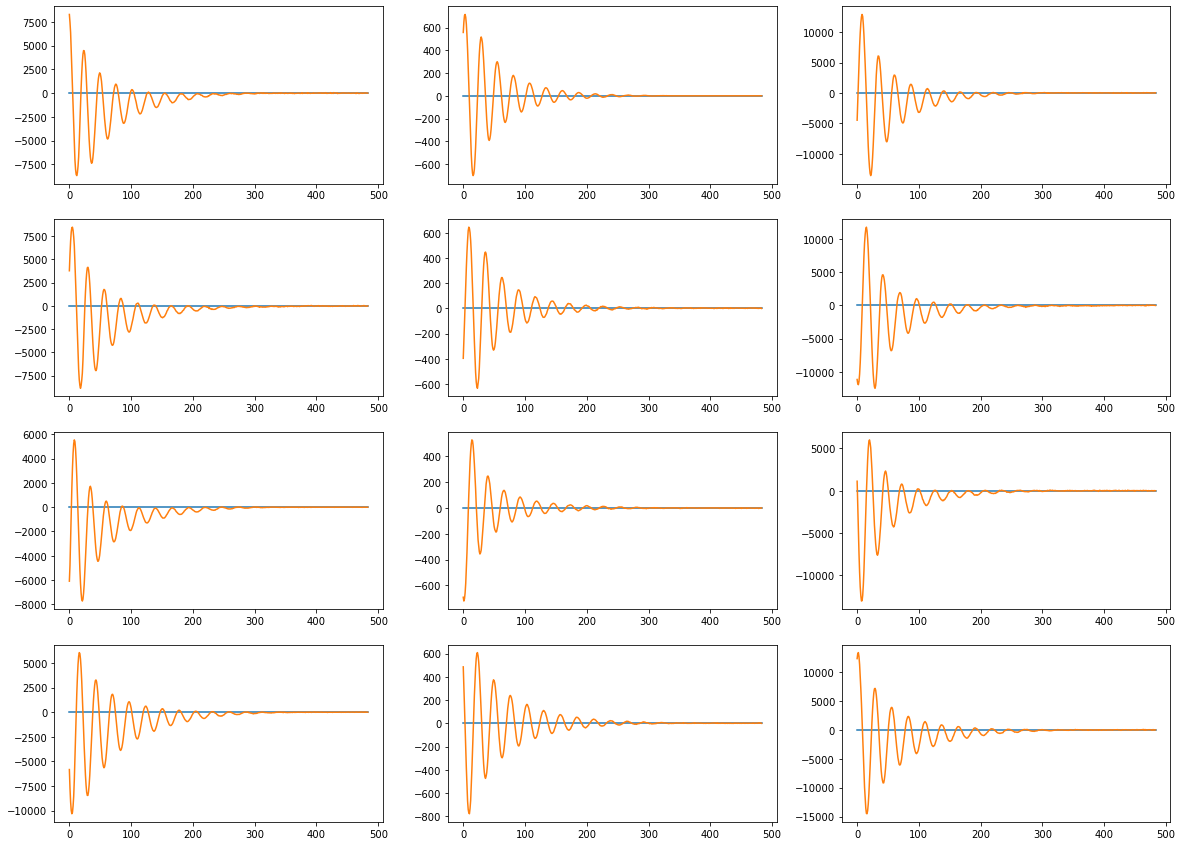

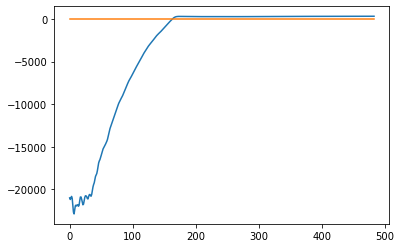

In [21]:
# plt.plot(bop_obj_list[num].dynamics.real.T/bop_obj_list[num].amplitudes)

# print(np.shape(bop_obj_list[num].dynamics.T))

# print(np.shape(bop_obj_list[num].modes))


b = voltage_trajectory_list[0][100,:].T@bop_obj_list[num].modes

# print(np.abs(b))

bop_state_recon = (bop_obj_list[num].dynamics.real.T )@bop_obj_list[num].modes.T
state = np.zeros(np.shape(voltage_trajectory_list[0][1772::,:]))

z_star = np.exp([i*experiment_time[1772::] for i in bop_obj_list[num].eigs])
z_star = [z_star[i,:]*b[i] for i in range(len(b))]

z_tilde = bop_obj_list[num].modes @ z_star


# print(bop_obj_list[num].amplitudes)
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(z_tilde[i,:]))
#     plt.plot(np.real(bop_state_recon[:,i]))
    plt.plot(voltage_trajectory_list[0][1772::,i])
#     plt.plot((bop_obj_list[num].dynamics.T / bop_obj_list[num].amplitudes)@bop_obj_list[num].modes.T)

plt.figure()
plt.plot(voltage_trajectory_list[0][1772::,12])
plt.plot(np.real(z_tilde[12,:]))

# print(b)
# print(bop_obj_list[num].amplitudes)

## Below is just multiplying dynamics and modes for reconstruction, as opposed to doing this 'post fitting'

27


C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


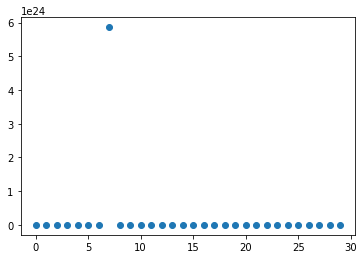

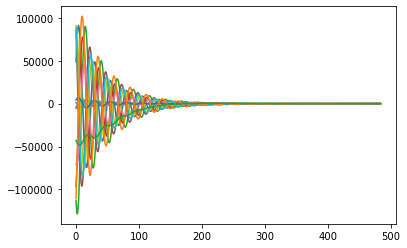

In [22]:
recon_error = np.zeros(len(bop_obj_list))

for i in range(len(recon_error)):
    bop_recon = bop_obj_list[i].reconstructed_data.real.T
    recon_error[i] = np.linalg.norm(voltage_trajectory_list[0][1772::,:] - bop_recon )

# bop_state_recon = (bop_obj_list[15].dynamics.real.T )@bop_obj_list[15].modes.T

# print((bop_obj_list[num].amplitudes))
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(np.real(bop_state_recon[:,i]))
#     plt.plot(voltage_trajectory_list[0][1776::,i])
    
len(recon_error)
plt.scatter(np.arange(len(recon_error)),recon_error)
print(np.argmin(recon_error))
plt.figure()
plt.plot(bop_obj_list[6].dynamics.T@bop_obj_list[6].modes.T)

Text(0, 0.5, 'imag')

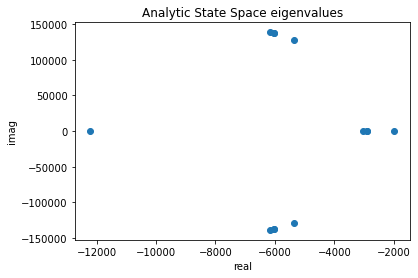

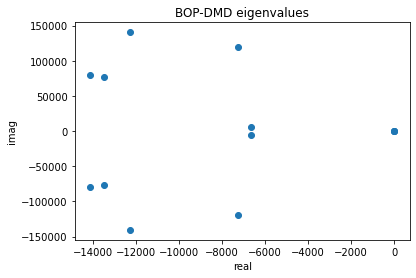

In [23]:


plt.figure()
plt.title('Analytic State Space eigenvalues')
plt.scatter(np.real(np.linalg.eigvals(A_plasma)),np.imag(np.linalg.eigvals(A_plasma)))
plt.xlabel('real')
plt.ylabel('imag')


lam_matrix = np.diag(bop_obj_list[num].eigs)
    
# print(np.shape(bop_obj_list[num].modes))
# print(b)
# b[8] = b[0]

bop_A = (bop_obj_list[num].modes)@(lam_matrix)@np.linalg.pinv(bop_obj_list[num].modes)


# print(np.diag(lam_matrix))
# print(np.diag(lam_matrix)/np.abs(b))

plt.figure()
plt.title('BOP-DMD eigenvalues')
# plt.scatter(np.real(bop_obj_list[num].eigs),np.imag(bop_obj_list[num].eigs))
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[num])),np.imag(np.linalg.eigvals(Atilde_list[num])))
plt.xlabel('real')
plt.ylabel('imag')

# plt.scatter(np.imag(np.linalg.eigvals(bop_A)),np.real(np.linalg.eigvals(bop_A)))

# print(np.linalg.eigvals(A))



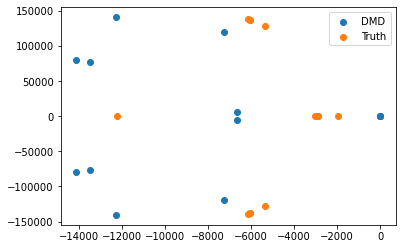

In [24]:
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[num])),np.imag(np.linalg.eigvals(Atilde_list[num])))
plt.scatter(np.real(np.linalg.eigvals(A_plasma)),np.imag(np.linalg.eigvals(A_plasma)))
plt.legend(['DMD','Truth'])

C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


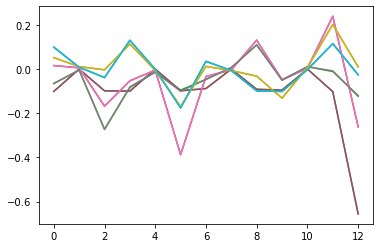

In [25]:
plt.plot(bop_obj_list[num].modes)

In [26]:
print(bop_obj_list[num].eigs)

[-12266.19550307-140498.64721857j  -7245.45084676-119406.87776915j
 -14125.46451657 -80062.18116648j -13494.74528913 -76484.65293445j
  -6665.64224359  -5882.9798552j   -6665.64224359  +5882.9798552j
 -13494.74528913 +76484.65293445j -14125.46451657 +80062.18116648j
  -7245.45084676+119406.87776915j -12266.19550307+140498.64721857j]


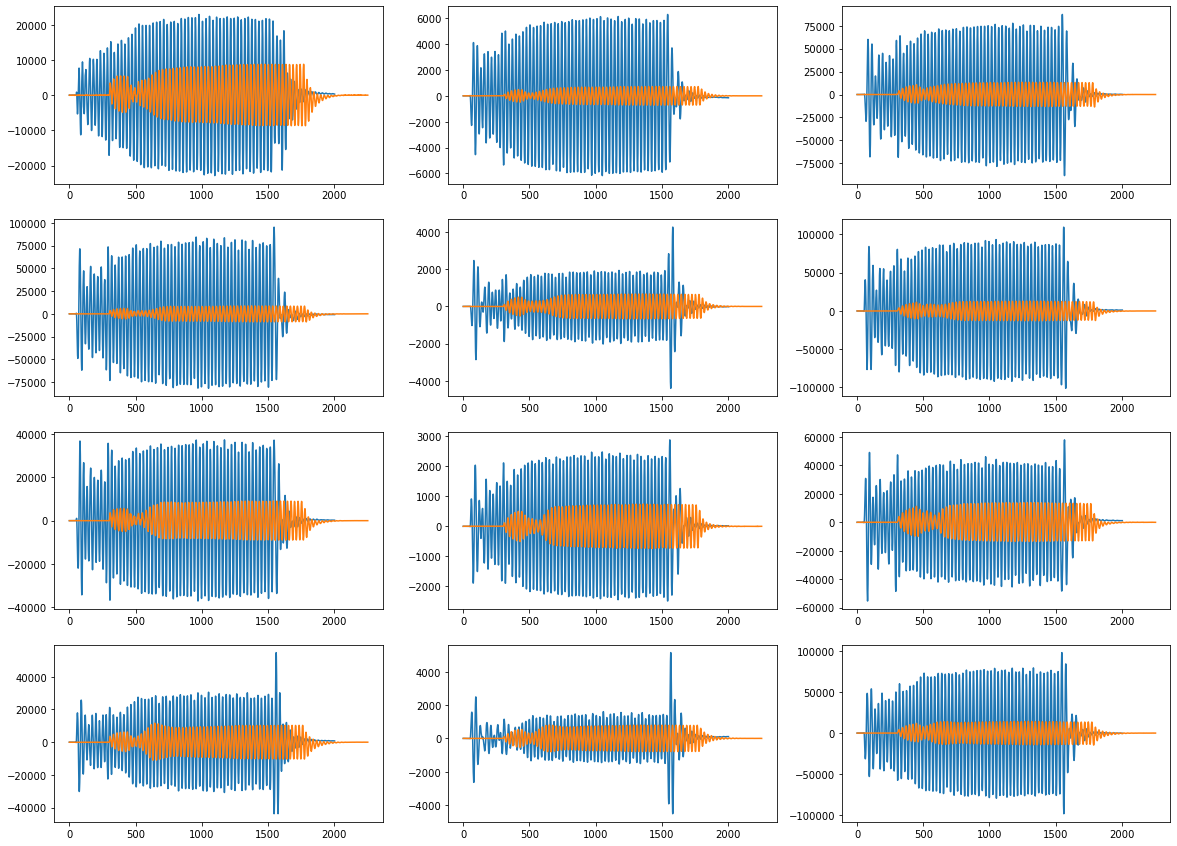

In [27]:
tout,yout,xout_bop_projected = lsim((bop_A,np.vstack((B,np.zeros((1,4)))),np.hstack((C,np.zeros((4,1)))),D),voltage_inputs_list[0][251::,:],experiment_time[251::])
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_bop_projected[:,i]))
    plt.plot(voltage_trajectory_list[0][:,i])

## Just for shits, what if we don't include the plasma current?

In [28]:
# Atilde_list = []
# bop_obj_list = []
# xout_list = []
# for i in range(40):
#     [Atilde,bop_obj,xout] = bopdmd_train_test(
#         svd_rank  = i+1,
#         num_trials = 20,
#         training_set = voltage_trajectory_list[0].T[0:12,1772::], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
#         training_voltage = voltage_inputs_list[0][1772::,:],
#         test_voltage = voltage_inputs_list[0][251::,:],
#         train_time = experiment_time[1772::],
#         test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
#         Btilde = B,#np.vstack((B,np.zeros((1,4)))),
#         C = C,#np.hstack((C,np.zeros((4,1)))),
#         D = D,
#         return_training_fit = False,
#         conjugate_bool = True, stable_bool = True,
#         noise_level = 0,
#         evaluate = True)
#     Atilde_list.append(Atilde)
#     bop_obj_list.append(bop_obj)
#     xout_list.append(xout)


In [29]:
# num = 13




# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(np.real(xout_list[num][:,i]))
#     plt.plot(voltage_trajectory_list[0][:,i])
#     plt.legend(['BOP','Test'])

## Let's see how well the vacuum model actually fits the plasma data.

In [30]:
tout,yout,xout_vacuum = lsim((bop_A_vacuum,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])



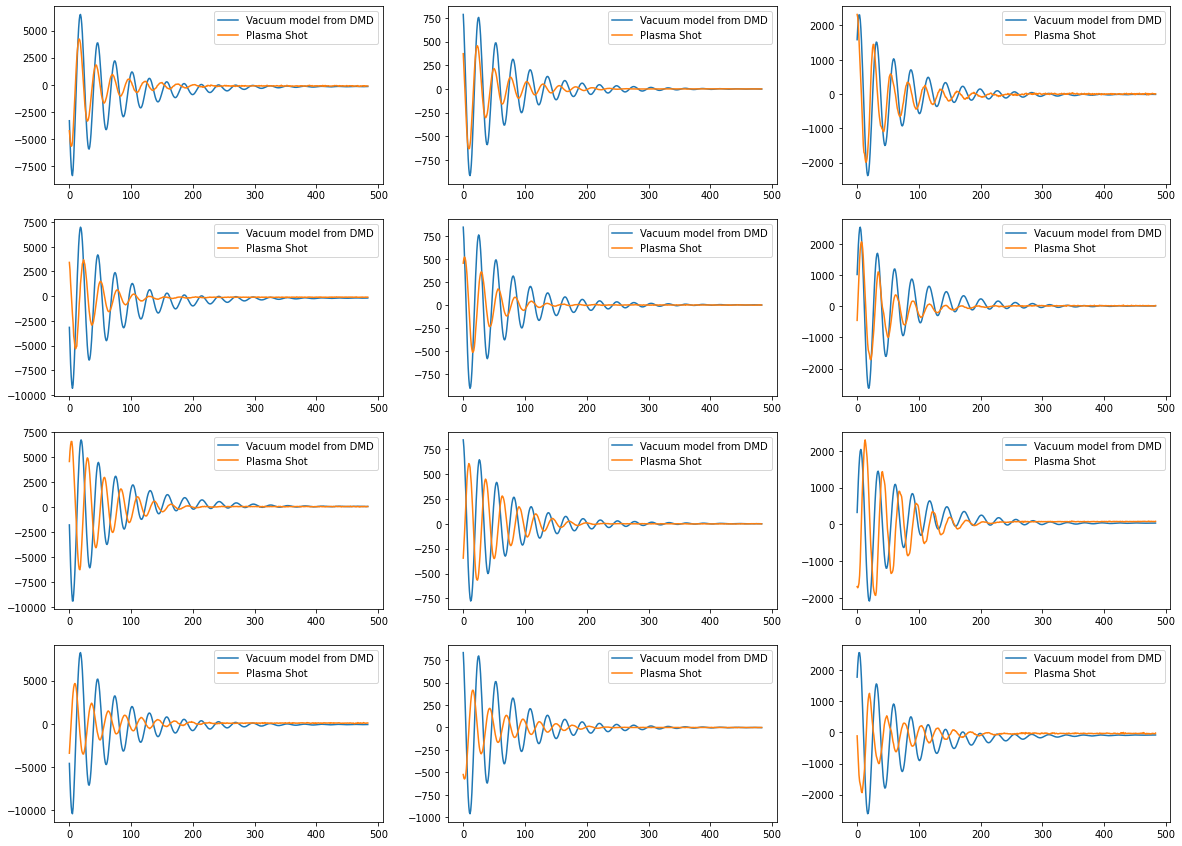

In [31]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_vacuum[1521:,i]))
    plt.plot(flux_trajectory_list[0][1521+251::,i])
    plt.legend(['Vacuum model from DMD','Plasma Shot'])
    
    


## In the cells below we try to formulate this problem as finding the smallest matrix that can be added to the vacuum DMD model to get a good plasma model

In [32]:
sfd = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 23})

flux_plasma_derivative = sfd._differentiate(flux_trajectory_list[0][251::,:],experiment_time[251::])


bop_A_vacuum_aug = np.vstack((bop_A_vacuum,np.zeros((1,12))))
bop_A_vacuum_aug = np.hstack( (bop_A_vacuum_aug, (np.zeros((13,1))) ) )
B_aug = np.vstack((B,np.zeros((1,4))))
C_aug = np.hstack((C,np.zeros((4,1))))

x_dot = flux_plasma_derivative[1521:,:].T
x = flux_trajectory_list[0][1772::,0:13].T
u = flux_inputs_list[0][1772::,:].T

# l = 4e10
# E = cp.Variable((13,13))

# objective = cp.Minimize(l*cp.norm(E.flatten(),2) + (1/250)*cp.sum_squares(x_dot - B_aug@(u) - 
# (A_plasma+E)@(x) ))

# prob = cp.Problem(objective)

In [33]:
def obj1(E_flat,hyper):
    E_flat = E_flat
    E = E_flat.reshape(13,13)

#     print(np.shape(E_flat))
    loss = hyper*np.linalg.norm(E) + np.mean( (x_dot - B_aug@(u) - 
    (bop_A_vacuum_aug+E)@(x) )**2 )
    return (loss)

def obj2(hyper):
    init_guess = np.random.uniform(-1,1,(13,13))
    res = scipy.optimize.minimize(obj1,init_guess,args = (hyper,))
    return obj1(res.x,hyper=hyper)

# obj = l*np.linalg.norm(E.flatten(),2) + np.mean( (x_dot - B_aug@(u) - 
# (bop_A_vacuum_aug+E)@(x) )**2 )

hyper_guess = 3e10


hyper_list = np.linspace(3e10,4e10,1000)

losses = []
# 
for i in range(len(hyper_list)):
    losses.append(obj1(np.random.uniform(-1,1,(13,13)),hyper_list[i]))
    
print(np.argmin(losses))

print(hyper_list[np.argmin(losses)])

res = scipy.optimize.minimize(obj1,np.random.uniform(-1,1,(13,13)),hyper_list[np.argmin(losses)])

115
31151151151.15115


C:\Users\ducks\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\ducks\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


In [34]:
# res = prob.solve(verbose = True)

# print(res)

print(np.linalg.norm(res.x))

38.93580622598764


23812.30875235282
1330646.1118911959


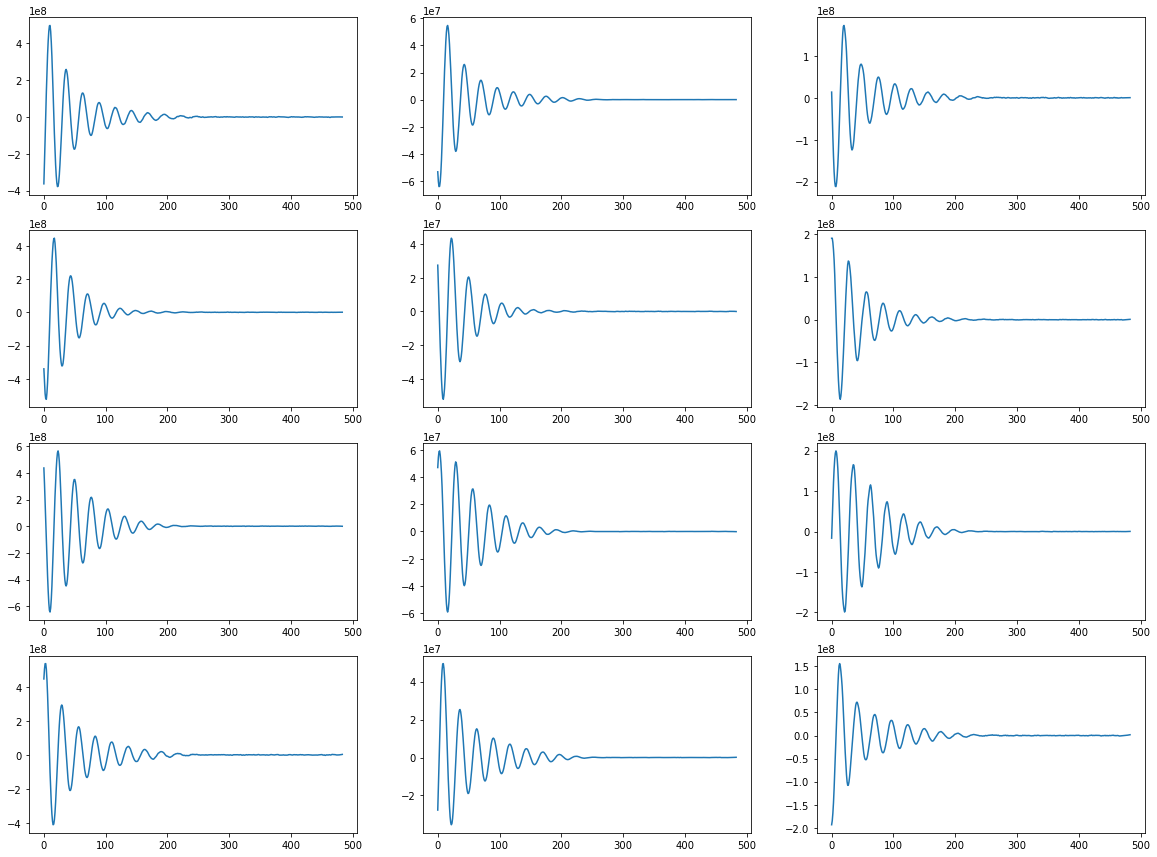

In [35]:

plt.figure(figsize = (20,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_plasma_derivative[1521::,i])
    
#Since we only computed the derivatives from 251 samples onward, we need to correct when doing least squares

# print(np.shape(flux_inputs_list[0]))
# print(np.shape(flux_trajectory_list[0]))
# print(np.shape(flux_plasma_derivative))
# print(np.shape(bop_A))

bop_A_vacuum_aug = np.vstack((bop_A_vacuum,np.zeros((1,12))))
bop_A_vacuum_aug = np.hstack( (bop_A_vacuum_aug, (np.zeros((13,1))) ) )
B_aug = np.vstack((B,np.zeros((1,4))))
C_aug = np.hstack((C,np.zeros((4,1))))



pert_A = bop_A_vacuum_aug + res.x.reshape(13,13)
# print(np.shape(pert_A))
print(np.linalg.norm(bop_A_vacuum_aug)/ np.linalg.norm(bop_A_vacuum_aug - (bop_A_vacuum_aug+res.x.reshape(13,13)) ))
print(np.linalg.norm(pert_A.T - bop_A_vacuum_aug))

## It does a terrible job! Added matrix corrupts the stability of the underlying DMD model

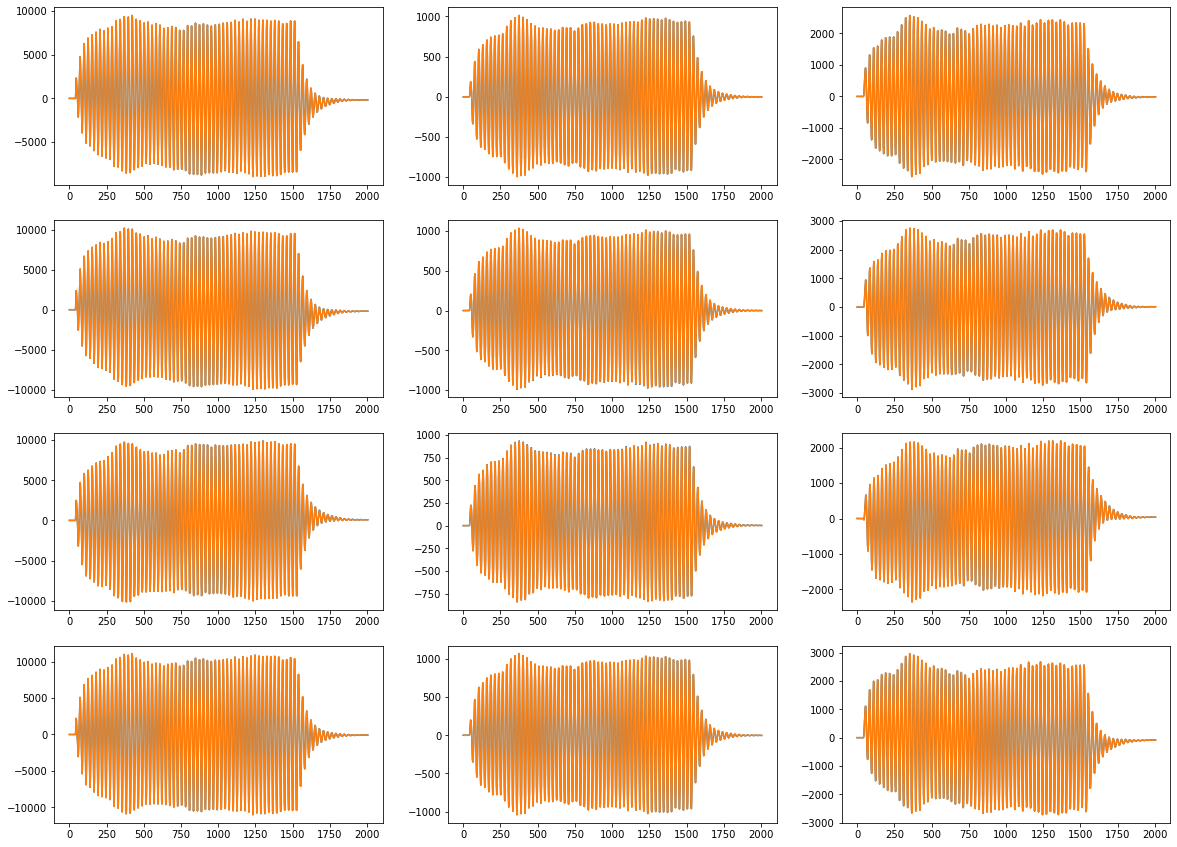

In [36]:
tout,yout,xout_pert = lsim((pert_A,B_aug,C_aug,D),flux_inputs_list[0][251::,:],experiment_time[251::])

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_pert[:,i]))
#     plt.plot(flux_trajectory_list[0][251::,i])
    plt.plot(np.real(xout_vacuum[:,i]))

## DMD on the residual

In [37]:
xout_residual = np.real(xout_vacuum[:,:]) - flux_trajectory_list[0][251::,0:12]
print(len(xout_residual))
print(len(flux_inputs_list[0][1772::,:]))
Atilde_residual_list = []
bop_residual_obj_list = []
xout_residual_list = []
for i in range(40):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 30,
        training_set = xout_residual[1521::,:].T, #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = flux_inputs_list[0][1772::,:],
        test_voltage = flux_inputs_list[0][251::,:],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,#np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
#     print(i)
    Atilde_residual_list.append(Atilde)
    bop_residual_obj_list.append(bop_obj)
    xout_residual_list.append(xout)

2005
484


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


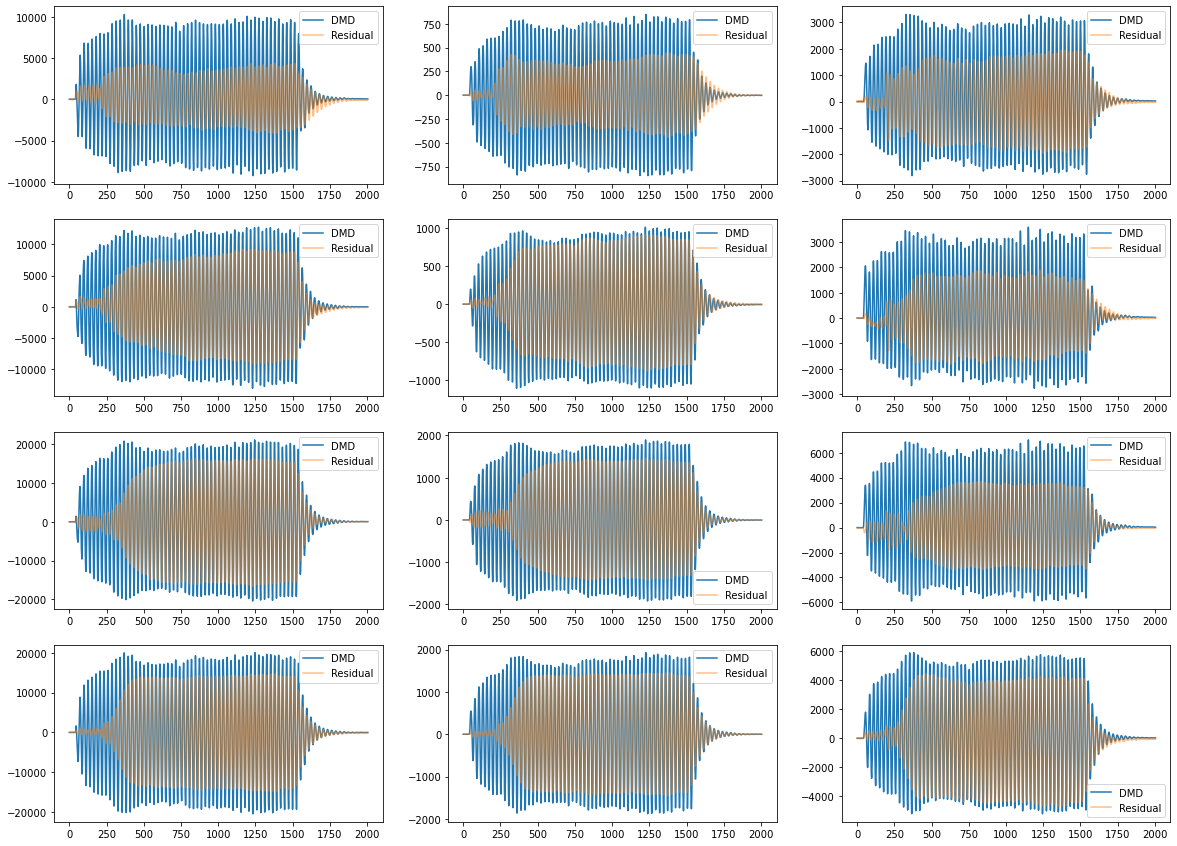

In [38]:
num = 3

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_residual_list[num][:,i]))
    plt.plot(xout_residual[:,i],alpha = .5)
    
    plt.legend(['DMD','Residual'])

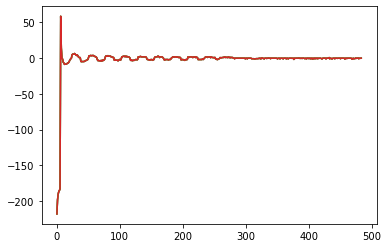

In [39]:
experiment_time[1772]
plt.plot(flux_inputs_list[0][1772::,:])

(2005, 12)
(12, 12)


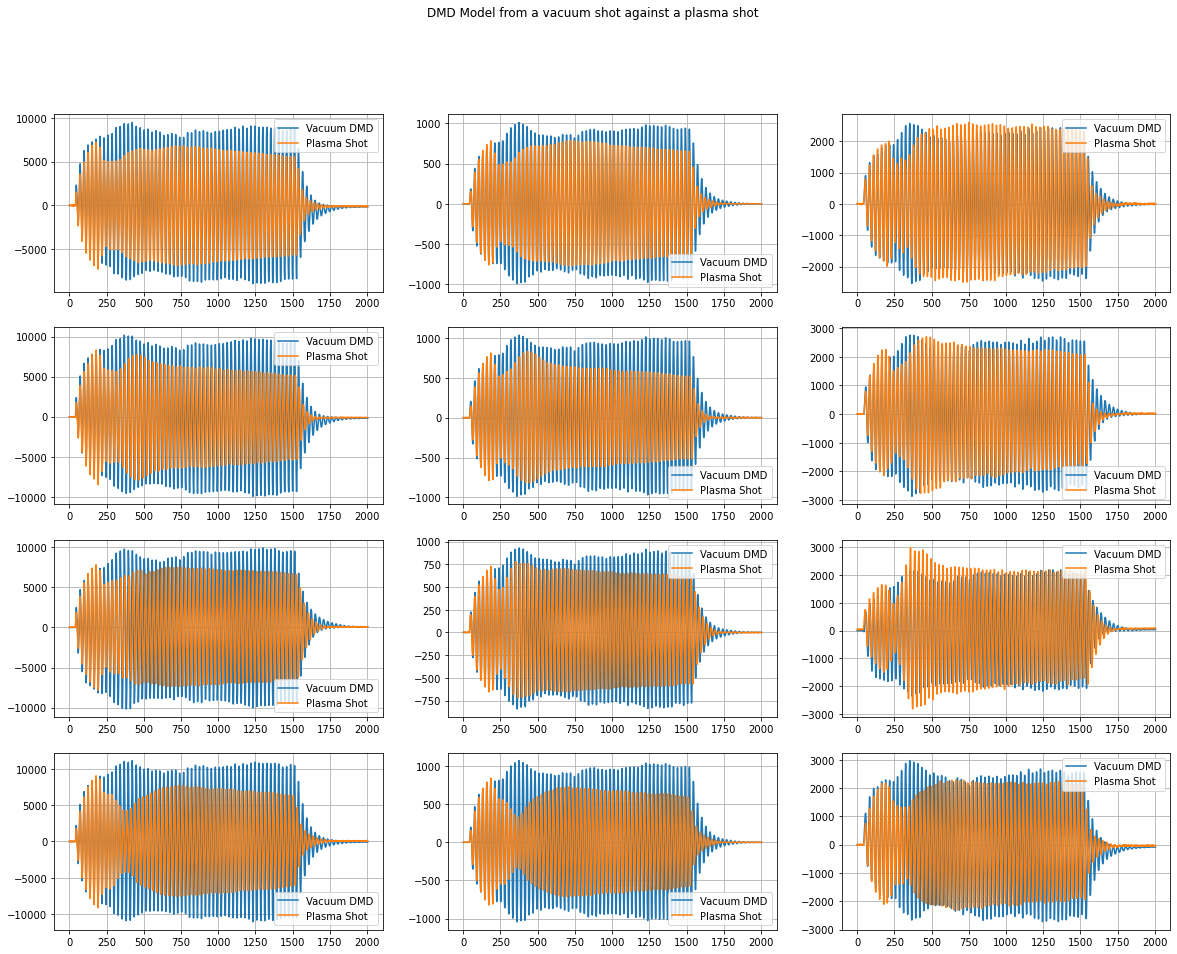

In [40]:
u,s,vt = np.linalg.svd(flux_trajectory_list[0][251::,0:12],full_matrices = False)

print(np.shape(u))
print(np.shape(vt))

res_A = bop_A_vacuum #+ 600*np.eye(12)

    
tout,yout,xout = lsim((res_A,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])


plt.figure(figsize = (20,15))
plt.suptitle('DMD Model from a vacuum shot against a plasma shot ')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout[:,i]))
    plt.plot(flux_trajectory_list[0][251::,i])
    plt.legend(['Vacuum DMD','Plasma Shot'])
    plt.grid()

(2005, 12)
(12, 12)


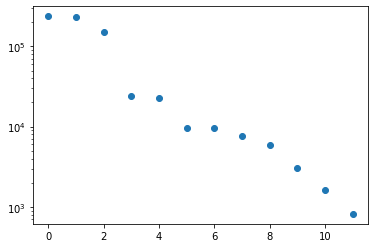

In [41]:
u,s,vt = np.linalg.svd(flux_trajectory_list[0][251::,0:12],full_matrices = False)

print(np.shape(u))
print(np.shape(vt))

plt.scatter(np.arange(len(s)),s)
plt.yscale('log')


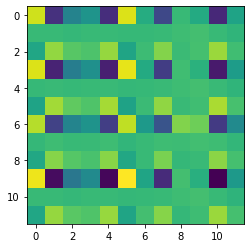

In [42]:
plt.imshow(bop_A_vacuum.real)

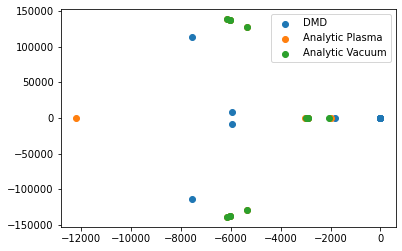

In [43]:
# plt.scatter(np.linalg.eigvals(Atilde_residual_list[3]).real,np.linalg.eigvals(Atilde_residual_list[3]).imag)
plt.scatter(np.linalg.eigvals(bop_A_vacuum).real,np.linalg.eigvals(bop_A_vacuum).imag)
plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag)
plt.scatter(np.linalg.eigvals(A).real,np.linalg.eigvals(A).imag)
plt.legend(['DMD','Analytic Plasma','Analytic Vacuum'])

## Can we model this system as the vacuum model being acted upon by some unitary matrix that rotates the eigenvalues and eigenvectors of the system? This will preserve stability by construction. We can also force that this unitary matrix is close to the identity. 

In [44]:
# Atilde_vacuum_list = []
# bop_vacuum_obj_list = []
# xout_vacuum_list = []
# for i in range(40):
#     [Atilde,bop_obj,xout] = bopdmd_train_test(
#         svd_rank  = i+1,
#         num_trials = 20,
#         training_set = np.flip(voltage_trajectory_list[0].T[0:12,300:400]), #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
#         training_voltage = voltage_inputs_list[0][300:400,:],
#         test_voltage = voltage_inputs_list[0][251::,:],
#         train_time = experiment_time[300:400],
#         test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
#         Btilde = B,#np.vstack((B,np.zeros((1,4)))),
#         C = C,#np.hstack((C,np.zeros((4,1)))),
#         D = D,
#         return_training_fit = False,
#         conjugate_bool = True, stable_bool = True,
#         noise_level = 0,
#         evaluate = True)
#     Atilde_vacuum_list.append(Atilde)
#     bop_vacuum_obj_list.append(bop_obj)
#     xout_vacuum_list.append(xout)


In [45]:
U = cp.Variable((12,12))
x_dot = flux_plasma_derivative[1521:,0:12].T
x = flux_trajectory_list[0][1772::,0:12].T
u = flux_inputs_list[0][1772::,:].T
# cost = (1/(len(x)))*cp.sum_squares(x_dot - U@bop_A_vacuum@x)

# I = np.eye(12)

# prob = cp.Problem(cp.Minimize(cost),[U@cp.conj(U).T == I])

# prob.solve(verbose = True)

# Unitary,sca = scipy.linalg.orthogonal_procrustes((bop_A_vacuum@x).T,x_dot.T)

# A_pro = (bop_A_vacuum@x)
# B_pro = x_dot


def obj_unitary(V,l = 100):
    V_hat = V.reshape(12,12)
#     print(V_hat)
    loss = np.linalg.norm(x_dot - V_hat@bop_A_vacuum@x)**2 #+ l*np.linalg.norm(V_hat - np.eye(12))

In [46]:

# scipy.linalg.orthogonal_procrustes?
np.random.uniform(0,1,(12,12))
V_hat = np.random.uniform(0,1,(12,12))
np.linalg.norm(x_dot - V_hat@bop_A_vacuum@x)**2
# res = scipy.optimize.minimize(obj_unitary,np.random.uniform(0,1,(12,12)))

5.326960674555316e+20

In [47]:
print(np.shape(res.x))

(169,)


In [48]:
vals,vecs = np.linalg.eig(Unitary)
vals[:].real = -1
Unitary_tilde = vecs@np.diag(vals)@vecs.T

print(np.shape(Unitary_tilde))

tout,yout,xout_unitary = lsim((bop_A_vacuum@Unitary_tilde,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])

print((vals))

print(np.linalg.eigvals(bop_A_vacuum@Unitary_tilde).real)


plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_unitary[:,i].real)

NameError: name 'Unitary' is not defined

In [ ]:
# M = B_pro@A_pro.T

# U,S,Vt = np.linalg.svd(M)

# print(np.shape(U@Vt))

# # np.linalg.eigvals(U@Vt@bop_A_vacuum).real

# sigma_last = np.linalg.det(U@Vt) + 1

# s_prime = np.ones(len(S))

# s_prime[-1] = sigma_last

# R = U@np.diag(s_prime)@Vt

